0.0
0.00125
0.0025
0.00375
0.005
0.00625
0.0075
0.00875
0.01
0.01125
0.0125
0.01375
0.015
0.01625
0.0175
0.01875
0.02
0.02125
0.0225
0.02375
0.025
0.02625
0.0275
0.02875
0.03
0.03125
0.0325
0.03375
0.035
0.03625
0.0375
0.03875
0.04
0.04125
0.0425
0.04375
0.045
0.04625
0.0475
0.04875
0.05
0.05125
0.0525
0.05375
0.055
0.05625
0.0575
0.05875
0.06
0.06125
0.0625
0.06375
0.065
0.06625
0.0675
0.06875
0.07
0.07125
0.0725
0.07375
0.075
0.07625
0.0775
0.07875
0.08
0.08125
0.0825
0.08375
0.085
0.08625
0.0875
0.08875
0.09
0.09125
0.0925
0.09375
0.095
0.09625
0.0975
0.09875
0.1
0.10125
0.1025
0.10375
0.105
0.10625
0.1075
0.10875
0.11
0.11125
0.1125
0.11375
0.115
0.11625
0.1175
0.11875
0.12
0.12125
0.1225
0.12375
0.125
0.12625
0.1275
0.12875
0.13
0.13125
0.1325
0.13375
0.135
0.13625
0.1375
0.13875
0.14
0.14125
0.1425
0.14375
0.145
0.14625
0.1475
0.14875
0.15
0.15125
0.1525
0.15375
0.155
0.15625
0.1575
0.15875
0.16
0.16125
0.1625
0.16375
0.165
0.16625
0.1675
0.16875
0.17
0.17125
0.1725
0.17375
0.175

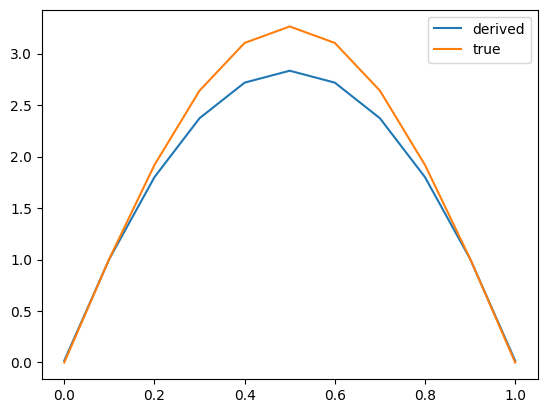

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from math import sqrt

def f(x, t):
    return (np.pi**2 - 1) * np.exp(-t) * np.sin(np.pi * x)

def K_M(N, h):
    Ne = N - 1
    K = np.zeros((N, N))
    M = np.zeros((N, N))

    for k in range(Ne):
        mlocal = np.zeros((2, 2))
        klocal = np.zeros((2, 2))
        # for l in range(2):
        #     for m in range(2):
        #         klocal[l][m] = -1 / h
        #         if l == m:
        #             klocal[l][m] = 1/h
        #         mlocal[l][m] = h / 6  # Elemental mass matrix
        #         if l == m:
        #             mlocal[l][m] = h/3
        for l in range(2):
            for m in range(2):
                klocal[l, m] = -1 / h if l != m else 1 / h
                mlocal[l, m] = h / 6 if l != m else h / 3
        for l in range(2):
            globalnode1 = k + l
            for m in range(2):
                globalnode2 = k + m
                K[globalnode1, globalnode2] += klocal[l, m]
                M[globalnode1, globalnode2] += mlocal[l, m]

    return K, M

def apply_dirichlet_bc(K, F, u_db, dirichlet_nodes):
    """Apply Dirichlet boundary conditions to the stiffness matrix and force vector."""
    for i in dirichlet_nodes:
        for j in range(K.shape[0]):
            if i != j:
                F[j] -= K[j, i] * u_db[i]
                K[j, i] = 0  # Set column to zero
                K[i, j] = 0  # Set row to zero
        K[i, i] = 1
        F[i] = u_db[i]
    return K, F
def u_boundary(x):
    return np.sin(np.pi * x)

def main():
    N = 11
    xi = np.linspace(0, 1, N)
    h = xi[1] - xi[0]

    dt = 1 / 800
    tf = 1
    t0 = 0
    nt = int((tf - t0) / dt)
    ctime = t0

    K, M = K_M(N, h)

    M_inv = np.linalg.inv(M)
    dx_de = h / 2

    phi = lambda eta: [(1 - eta) / 2, (1 + eta) / 2]
    q1 = -1 / sqrt(3)
    q2 = 1 / sqrt(3)

    u = np.zeros(( N,nt + 1))  # Time-dependent solution array
    u[:, 0] = u_boundary(xi)
    # u[0,0],u[0,-1] = u_boundary(xi[0]), u_boundary(xi[-1])
    
    # Set Dirichlet boundary conditions
    u_db = np.zeros(N)  # Prescribed values (e.g., zero at boundaries)
    dirichlet_nodes = [0, N - 1]  # Dirichlet nodes at boundaries

    for n in range(nt):
        ctime = t0 + n * dt
        F = np.zeros(N)
        for k in range(N - 1):
            flocal = np.zeros(2)
            # for l in range(2):
            #     #flocal[l] = (f(2/h * q1 - 1, ctime) * phi(q1)[l] + f(2/h * q2 - 1, ctime) * phi(q2)[l])  * 2
            #     # flocal[l] = (f(2/h * q1 - 1, ctime) + f(2/h * q2 - 1, ctime))  * 2
            #     # flocal[l] = (f(q1, ctime) + f(q2, ctime))  * 2 
            #     flocal[l] = (f(h/2 * (q1+1), ctime) + f(h/2*(q2+1), ctime))  * 2 * dx_de 
            #     # print("f",f(2/h * q2 - 1, ctime) )
            for l in range(2):
                # flocal[l] = (f(xi[k] + h / 2 * (q1 + 1), ctime) * phi(q1)[l] + f(xi[k] + h / 2 * (q2 + 1), ctime) * phi(q2)[l])  *dx_de *2
                flocal[l] = (f(h/2 * (q1+1), ctime) + f(h/2*(q2+1), ctime))

            for l in range(2):
                globalnode = k + l
                F[globalnode] += flocal[l]
         
        # print("F",F)
        # Apply Dirichlet boundary conditions to K and F
        K_bc, F_bc = apply_dirichlet_bc(K.copy(), F.copy(), u_db, dirichlet_nodes)
        # print("K_bc", K_bc)
        # print("F_bc", F_bc)
        # Time-stepping method (Forward Euler here)
        method = 'FE'
        if method == 'FE':
            # F_bc = np.zeros(N)
            # print(u[:,0])
            u[:,n + 1] = u[:,n] - dt * M_inv @ K_bc @ u[:,n] + dt * M_inv @ F_bc
            # print("u_t", u[:,n + 1])
        print(n/nt)
    # print("U",u)
    plt.plot(xi,u[:,-1], label = "derived")
    plt.plot(xi, f(xi, 1), label = "true")
    print("a",np.max(f(xi,1)) - np.max(u[:,int(len(xi)/2)]))
    plt.legend()
    plt.show()
if __name__ == "__main__":
    main()


0.0
a -0.06793242589843729


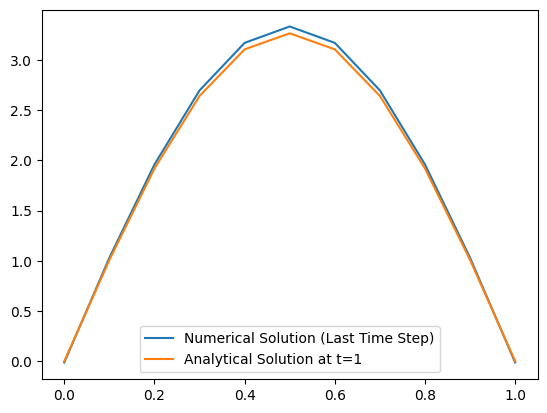

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from math import sqrt

def f(x, t):
    return (np.pi**2 - 1) * np.exp(-t) * np.sin(np.pi * x)

def K_M(N, h):
    Ne = N - 1
    K = np.zeros((N, N))
    M = np.zeros((N, N))

    for k in range(Ne):
        mlocal = np.zeros((2, 2))
        klocal = np.zeros((2, 2))
        for l in range(2):
            for m in range(2):
                klocal[l, m] = -1 / h if l != m else 1 / h
                mlocal[l, m] = h / 6 if l != m else h / 3
        for l in range(2):
            globalnode1 = k + l
            for m in range(2):
                globalnode2 = k + m
                K[globalnode1, globalnode2] += klocal[l, m]
                M[globalnode1, globalnode2] += mlocal[l, m]

    return K, M

def apply_dirichlet_bc(K, F, u_db, dirichlet_nodes):
    for i in dirichlet_nodes:
        for j in range(K.shape[0]):
            if i != j:
                F[j] -= K[j, i] * u_db[i]
                K[j, i] = 0
                K[i, j] = 0
        K[i, i] = 1
        F[i] = u_db[i]
    return K, F

def u_boundary(x):
    return np.sin(np.pi * x)

def main():
    N = 11
    xi = np.linspace(0, 1, N)
    h = xi[1] - xi[0]

    dt = 1
    tf = 1
    t0 = 0
    nt = int((tf - t0) / dt)
    ctime = t0

    K, M = K_M(N, h)

    dx_de = h / 2

    phi = lambda eta: [(1 - eta) / 2, (1 + eta) / 2]
    q1 = -1 / sqrt(3)
    q2 = 1 / sqrt(3)
    
    quad_points = [-1/sqrt(3), 1/sqrt(3)]
    quad_weights = [1,1]
    # quad_points = [-0.8611363115940526, -0.3399810435848563, 
    #                0.3399810435848563, 0.8611363115940526]
    # quad_weights = [0.3478548451374538, 0.6521451548625461, 
    #                 0.6521451548625461, 0.3478548451374538]
    
    u = np.zeros((N, nt + 1))  
    u[:, 0] = u_boundary(xi)
    
    u_db = np.zeros(N)  
    dirichlet_nodes = [0, N - 1]  

    method = 'BE'  # Choose 'FE' for Forward Euler, 'BE' for Backward Euler

    for n in range(nt):
        print(n/nt)
        ctime = t0 + n * dt
        F = np.zeros(N)
        for k in range(N - 1):
            flocal = np.zeros(2)
            for l in range(2):
                for p in range(len(quad_points)):
                    flocal[l] += f(h/2 * (quad_points[p] + 1)+xi[k], ctime) * quad_weights[p] *h
            for l in range(2):
                globalnode = k + l
                F[globalnode] += flocal[l]

        K_bc, F_bc = apply_dirichlet_bc(K.copy(), F.copy(), u_db, dirichlet_nodes)

        if method == 'FE':
            M_inv = np.linalg.inv(M)
            u[:, n + 1] = u[:, n] - dt * M_inv @ K_bc @ u[:, n] + dt * M_inv @ F_bc

        elif method == 'BE':
            A = M + dt * K_bc
            b = M @ u[:, n] + dt * F_bc
            u[:, n + 1] = np.linalg.solve(A, b)
    print("a",np.max(f(.5,1)) - np.max(u[int(len(xi)/2),-1]))
    plt.plot(xi, u[:, -1], label="Numerical Solution (Last Time Step)")
    plt.plot(xi, f(xi, tf), label="Analytical Solution at t=1")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
